In [1]:
import pandas as pd
import numpy as np
import math
import os
from matplotlib import pyplot as plt
from PyRadioLoc.Utils.GeoUtils import GeoUtils
%run UtilsLightGBMFingerPrinting.ipynb

In [2]:
FILES = [
    
    './FinalResult/Resultados_Metodo_7.csv',  # CDB gerado com LightGBM dados Outdoor
    './FinalResult/Resultados_Metodo_8.csv',  # CDB gerado com LightGBM dados Indoor
    './FinalResult/Resultados_Metodo_9.csv',  # CDB gerado com LightGBM dados Indoor-Outdoor
    
    './FinalResult/Resultados_Metodo_10.csv',  # CDB gerado com SVR dados Outdoor
    './FinalResult/Resultados_Metodo_11.csv',  # CDB gerado com SVR dados Indoor
    './FinalResult/Resultados_Metodo_12.csv',  # CDB gerado com SVR dados Indoor-Outdoor
     
]
METHODS = [x.split("_")[-1].split(".")[0] for x in FILES]     # lista contendo os metodos que serão usados
db = pd.read_csv('databases/meds_pandas.csv')
erbs = pd.read_csv('databases/Bts.csv')
#errorLocation = pd.read_csv('result/erros.csv')
ERROS_CSV_FILE = './result/erros.csv' 

# 1. Análise dos Dados:

In [3]:
data = pd.read_csv("./databases/meds_pandas.csv")
data = data.drop("idx", axis = 1)
data = data.drop("indoor", axis = 1)
#round(data.describe(), 4)

In [4]:
# Gera o dataframe contendo os erros
errors_df = calculate_theorical_errors()
round(errors_df.describe(), 2)

,7,8,9,10,11,12
count,400.00,400.00,400.00,400.00,400.00,400.00
mean,39.62,74.26,56.55,42.55,85.46,67.81
std,37.46,28.34,36.46,38.81,22.26,38.14
min,0.90,21.40,1.19,0.65,32.13,2.61
25%,13.07,59.28,21.72,14.05,72.88,32.13
50%,26.26,78.90,59.28,28.97,83.71,72.88
75%,55.08,93.25,83.90,61.12,101.93,92.82
max,233.14,143.38,256.59,245.89,137.37,184.93


In [5]:
errors_df.to_csv(ERROS_CSV_FILE, index=False)

# 3. Histograma dos erros (em metros)

In [6]:
#greek_letterz=[chr(code) for code in range(945,970)]
#print(greek_letterz)

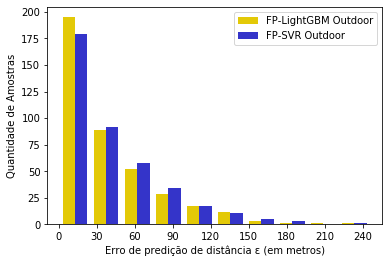

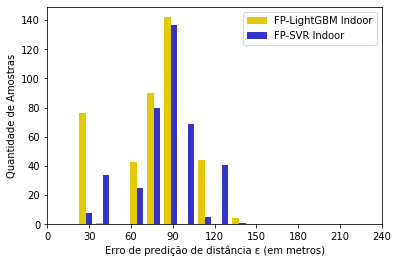

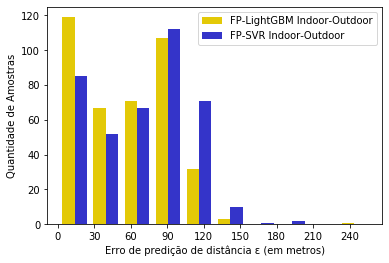

In [7]:
for i in range(0,3):
    environment = ['Outdoor', 'Indoor', 'Indoor-Outdoor']
    errorLocation = pd.read_csv(ERROS_CSV_FILE)
    score_FP_LightGBM = errorLocation[str(i + 7)]
    score_FP_SVR = errorLocation[str(i + 10)]
    legend = ['FP-LightGBM '+ environment[i], 'FP-SVR '+ environment[i]]
    plt.hist([score_FP_LightGBM, score_FP_SVR], color=['#e3c907', '#3434c9'])
    plt.xlabel("Erro de predição de distância "+chr(949)+" (em metros)")
    plt.ylabel("Quantidade de Amostras")
    plt.legend(legend)
    plt.xticks(np.arange(0, 250, 30))#Metros
    #plt.yticks(np.arange(0, 240, 10))# Amostras
    plt.savefig('./result/'+ environment[i]+'.png')  
    plt.show()

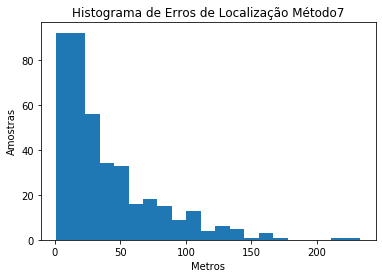

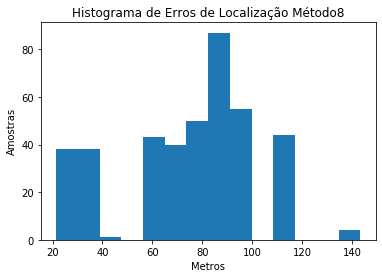

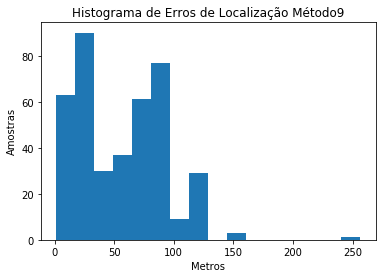

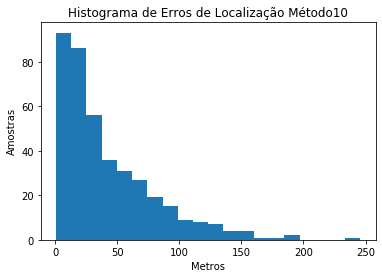

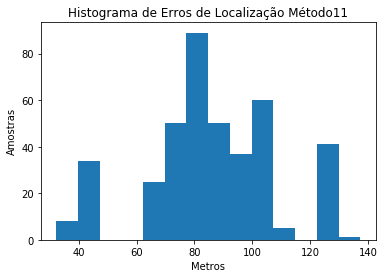

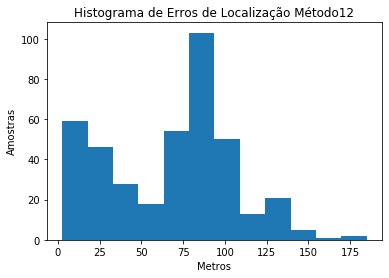

In [8]:
for i in METHODS:
    errorLocation = pd.read_csv(ERROS_CSV_FILE)
    plt.title("Histograma de Erros de Localização Método" + str(i))
    histogram_example = plt.hist(errorLocation[str(i)], bins='auto')
    plt.xlabel('Metros')
    plt.ylabel('Amostras')
    plt.show()

# 4. Boxplot dos erros (em metros)

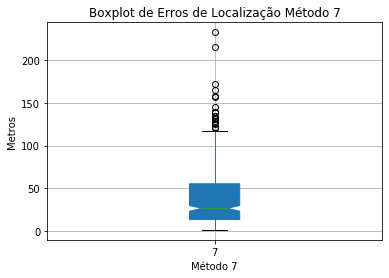

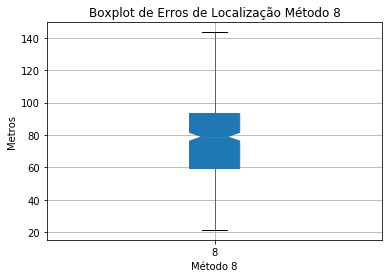

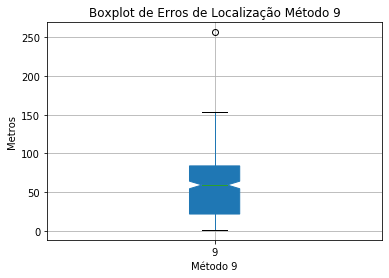

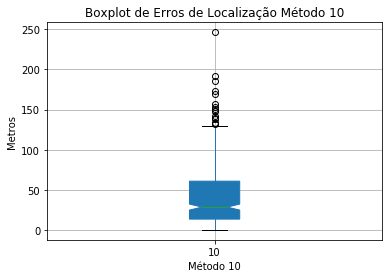

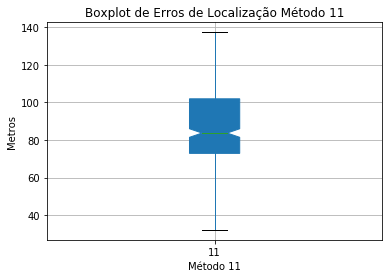

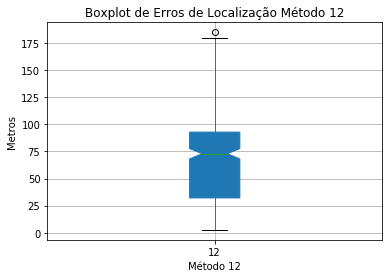

In [9]:
for i in METHODS:
    boxplotErrorLocationM1 = errorLocation.boxplot(column=[str(i)], notch = True, patch_artist = True)
    plt.title("Boxplot de Erros de Localização Método "+ str(i))
    plt.xlabel('Método '+ str(i))
    plt.ylabel('Metros')
    plt.show()

# Results k-fold:

In [36]:
Result = pd.read_csv("./result-k-fold/erros-LightGBM-k-fold.csv")
Result.head()

,1,2,3,4,5,6
0,76.09,65.02,114.14,42.50,28.53,70.47
1,73.86,55.05,100.45,69.04,42.13,48.74
2,95.92,65.02,119.46,39.06,28.53,34.72
3,109.60,71.57,79.62,91.92,96.42,26.11
4,101.94,42.25,139.06,53.87,50.32,65.81


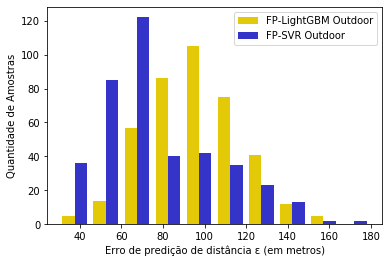

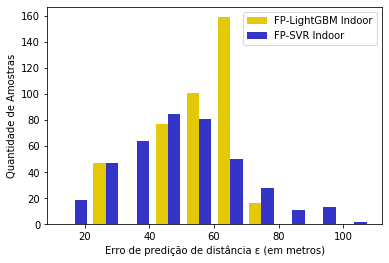

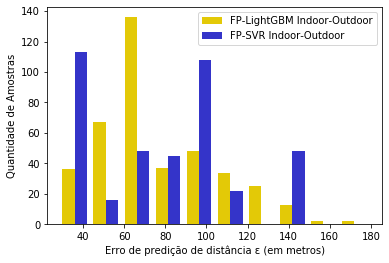

In [38]:
for i in range(0,3):
    environment = ['Outdoor', 'Indoor', 'Indoor-Outdoor']
    errorLocation = pd.read_csv("./result-k-fold/erros-LightGBM-k-fold.csv")
    score_FP_LightGBM = errorLocation[str(i + 1)]
    score_FP_SVR = errorLocation[str(i + 3)]
    legend = ['FP-LightGBM '+ environment[i], 'FP-SVR '+ environment[i]]
    plt.hist([score_FP_LightGBM, score_FP_SVR], color=['#e3c907', '#3434c9'])
    plt.xlabel("Erro de predição de distância "+chr(949)+" (em metros)")
    plt.ylabel("Quantidade de Amostras")
    plt.legend(legend)
    #plt.xticks(np.arange(0, 300, 50))#Metros
    #plt.yticks(np.arange(0, 180, 30))# Amostras
    plt.savefig('./result/'+ environment[i]+'.png')  
    plt.show()